In [ ]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class NeRF(nn.Module):
    def __init__(self, emb_dim_pos=10, emb_dim_dir=4, hidden_dim=128):
        super().__init__()
        self.emb_dim_pos = emb_dim_pos
        self.emb_dim_dir = emb_dim_dir

        self.block1 = nn.Sequential(
            nn.Linear(6*emb_dim_pos+3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
        )
        self.block2 = nn.Sequential(
            nn.Linear(hidden_dim + 6*emb_dim_pos+3, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )

        self.sigma = nn.Sequential(
            nn.Linear(hidden_dim, 1), nn.ReLU()        # non-negative
        )
        self.color = nn.Sequential(
            nn.Linear(hidden_dim + 6*emb_dim_dir+3, hidden_dim//2), nn.ReLU(),
            nn.Linear(hidden_dim//2, 3), nn.Sigmoid()  # RGB color
        )

    @staticmethod
    def positional_encoding(x, L):
        out = [x]
        for j in range(L):
            out.append(torch.sin(2 ** j * x))
            out.append(torch.cos(2 ** j * x))
        return torch.cat(out, dim=1)
    
    def forward(self, x, d):
        emb_x = self.positional_encoding(x, self.emb_dim_pos)  # (batch_size, 6*emb_dim_pos+3)
        emb_d = self.positional_encoding(d, self.emb_dim_dir)  # (batch_size, 6*emb_dim_dir+3)
        h = self.block1(emb_x)           # (batch_size, hidden_dim)
        h = torch.cat((h, emb_x), dim=1) # skip connection: (batch_size, hidden_dim + 6*emb_dim_pos+3)
        h = self.block2(h)               # (batch_size, hidden_dim)
        sig = self.sigma(h)              # (batch_size, 1)
        h = torch.cat((h, emb_d), dim=1) # viewing direction condition: (batch_size, hidden_dim + 6*emb_dim_dir+3)
        c = self.color(h)                # (batch_size, hidden_dim//2)
        return c, sig

In [ ]:
class NeRFDataset(Dataset):
    def __init__(self, images, ray_origins, ray_directions):
        self.images = images
        self.ray_origins = ray_origins
        self.ray_directions = ray_directions

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        return self.images[idx], self.ray_origins[idx], self.ray_directions[idx]

In [ ]:
def get_rays(height, width, focal_length, c2w):
    # Create meshgrid for pixel coordinates in the image plane
    i, j = torch.meshgrid(
        torch.arange(width, dtype=torch.float32).to(c2w.device),
        torch.arange(height, dtype=torch.float32).to(c2w.device),
        indexing='xy'  # Computer Graphics convention
    )

    # Compute directions in camera coordinates
    directions = torch.stack([
         (i - width * 0.5) / focal_length,
        -(j - height * 0.5) / focal_length,
        -torch.ones_like(i)
    ], dim=-1)  # (height, width, 3)

    # Convert directions to world coordinates
    rays_d = torch.sum(directions[..., None, :] * c2w[:3, :3], dim=-1)

    # Camera origin in world coordinates
    rays_o = c2w[:3, -1].expand(rays_d.shape)

    return rays_o, rays_d


def sample_stratified(ray_origins, tn, tf, n_samples, perturb=True):
    # number_of_rays = batch_size
    # ray_origins: (number_of_rays, 3)
    device = ray_origins.device

    # Get t values for sampling along each ray
    t = torch.linspace(tn, tf, n_samples, device=device)  # (n_samples)
    t = t.expand(ray_origins.shape[0], n_samples)         # (number_of_rays, n_samples): Repeat for all rays

    # Draw uniform samples from bins along ray (Stratified Sampling)
    if perturb:
        mid = (t[:, :-1] + t[:, 1:]) / 2.
        lower = torch.cat((t[:, :1], mid), -1)
        upper = torch.cat((mid, t[:, -1:]), -1)
        u = torch.rand(t.shape, device=device)
        t = lower + (upper - lower) * u  # (number_of_rays, n_samples)

    return t


def compute_accumulated_transmittance(alphas):
    # alphas: (number_of_rays, n_samples)

    accumulated_transmittance = torch.cumprod(alphas, dim=1)
    # (number_of_rays, n_samples): Accumulated transmittance at each bin

    ones = torch.ones((accumulated_transmittance.shape[0], 1), device=alphas.device)
    # (number_of_rays, 1): Transmittance at the first bin is 1

    transmittance = torch.cat((ones, accumulated_transmittance[:, :-1]), dim=-1)
    return transmittance  # (number_of_rays, n_samples): Transmittance at each bin


def get_nerf_inputs(t, ray_origins, ray_directions):
    # t: (number_of_rays, n_samples)
    # ray_origins: (number_of_rays, 3)
    # ray_directions: (number_of_rays, 3)

    # Compute the 3D points along each ray
    x = ray_origins.unsqueeze(1) + t.unsqueeze(2) * ray_directions.unsqueeze(1)  
    # (number_of_rays, n_samples, 3)

    d = ray_directions.expand(t.shape[1], ray_directions.shape[0], 3).transpose(0, 1) 
    # (number_of_rays, n_samples, 3); Repeat the same direction for all bins

    delta = torch.cat((t[:, 1:] - t[:, :-1], torch.tensor([1e10], device=t.device).expand(ray_origins.shape[0], 1)), -1)
    # (number_of_rays, n_samples): Distance between each bin along the ray
    return x, d, delta


def get_colors_and_weights(nerf_model, x, d, delta):
    # x: (number_of_rays, n_samples, 3)
    # d: (number_of_rays, n_samples, 3)

    # (number_of_rays*n_samples, 3), (number_of_rays*n_samples, 1)
    colors, sigma = nerf_model(x.reshape(-1, 3), d.reshape(-1, 3))
    colors = colors.reshape(x.shape)     # (number_of_rays, n_samples, 3)
    sigma = sigma.reshape(x.shape[:-1])  # (number_of_rays, n_samples)

    # Compute weights
    alpha = 1 - torch.exp(-sigma * delta)  # (number_of_rays, n_samples)
    weights = compute_accumulated_transmittance(1 - alpha).unsqueeze(2) * alpha.unsqueeze(2)
    # (number_of_rays, n_samples, 1)

    # Compute the pixel values as a weighted sum of colors along each ray
    c = (weights * colors).sum(dim=1)
    # (number_of_rays, n_samples, 1) * (number_of_rays, n_samples, 3) -> (number_of_rays, 3)

    return c, weights


def render_rays(nerf_model, t, ray_origins, ray_directions):
    x, d, delta = get_nerf_inputs(t, ray_origins, ray_directions)
    c, weights = get_colors_and_weights(nerf_model, x, d, delta)
    return c, weights

## Hierarchical Volume Sampling

The 3D space is in fact very sparse with occlusions and so most points don't contribute much to the rendered image. It is therefore more beneficial to oversample regions with a high likelihood of contributing to the integral. Here we apply learned, normalized weights to the first set of samples to create a PDF across the ray, then apply inverse transform sampling to this PDF to gather a second set of samples.

In [ ]:
def sample_pdf(bins, weights, n_samples, perturb=False):
    """ 
    Apply inverse transform sampling to a weighted set of points.
    """

    # Normalize weights to get PDF.
    w = weights.squeeze(-1) # [n_rays, n_samples]

    # [n_rays, n_samples] / [n_rays, 1] -> [n_rays, n_samples]
    pdf = (w + 1e-5) / torch.sum(w + 1e-5, -1, keepdims=True) 

    # Convert PDF to CDF.
    cdf = torch.cumsum(pdf, dim=-1) # [n_rays, n_samples]
    cdf = torch.concat([torch.zeros_like(cdf[..., :1]), cdf], dim=-1) # [n_rays, n_samples + 1]

    # Take sample positions to grab from CDF. Linear when perturb == 0.
    if not perturb:
        u = torch.linspace(0., 1., n_samples, device=cdf.device)
        u = u.expand(list(cdf.shape[:-1]) + [n_samples])                      # [n_rays, n_samples]
    else:
        u = torch.rand(list(cdf.shape[:-1]) + [n_samples], device=cdf.device) # [n_rays, n_samples]

    # Find indices along CDF where values in u would be placed.
    u = u.contiguous() # Returns contiguous tensor with same values.
    inds = torch.searchsorted(cdf, u, right=True) # [n_rays, n_samples]

    # Clamp indices that are out of bounds.
    below = torch.clamp(inds - 1, min=0)
    above = torch.clamp(inds, max=cdf.shape[-1] - 1)
    inds_g = torch.stack([below, above], dim=-1) # [n_rays, n_samples, 2]

    # Sample from cdf and the corresponding bin centers.
    matched_shape = list(inds_g.shape[:-1]) + [cdf.shape[-1]]
    cdf_g = torch.gather(cdf.unsqueeze(-2).expand(matched_shape), dim=-1,
                        index=inds_g)
    bins_g = torch.gather(bins.unsqueeze(-2).expand(matched_shape), dim=-1,
                            index=inds_g)

    # Convert samples to ray length.
    denom = (cdf_g[..., 1] - cdf_g[..., 0])
    denom = torch.where(denom < 1e-5, torch.ones_like(denom), denom)
    t = (u - cdf_g[..., 0]) / denom
    t_samples = bins_g[..., 0] + t * (bins_g[..., 1] - bins_g[..., 0])

    return t_samples # [n_rays, n_samples]

In [ ]:
def sample_hierarchical(t, weights, n_samples, perturb=True):
  """
  Apply hierarchical sampling to the rays.
  """

  # Draw samples from PDF using t as bins and weights as probabilities.
  t_mid = .5 * (t[..., 1:] + t[..., :-1])
  new_t_samples = sample_pdf(t_mid, weights.squeeze(-1)[..., 1:-1], n_samples, perturb=perturb)
  new_t_samples = new_t_samples.detach()
  # t: [n_rays, N_samples], new_t_samples: [n_rays, n_samples]

  # Resample points from ray based on PDF.
  t_combined, _ = torch.sort(torch.cat([t, new_t_samples], dim=-1), dim=-1)
  return t_combined # [n_rays, N_samples + n_samples]

In [ ]:
@torch.inference_mode()
def test(model_coarse, model_fine, ray_origins, ray_directions,
         tn=2, tf=6, Nc=64, Nf=128, H=100, W=100, 
         chunk_size=10, filename=None):
    """
    Args:
        model_coarse: coarse model
        model_fine: fine model
        ray_origins: ray origins for each pixel of the image
        ray_directions: ray directions for each pixel of the image
        tn (optional): near plane distance
        tf (optional): far plane distance
        chunk_size (int, optional): chunk size for memory efficiency. Defaults to 10.
        Nc (int, optional): number of coarse samples. Defaults to 64.
        Nf (int, optional): number of fine samples. Defaults to 128.
        H (int, optional): image height. Defaults to 100.
        W (int, optional): image width. Defaults to 100.
        
    Returns:
        None: None
    """

    pixels_fine = []     # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        # Get chunk of rays
        ray_o = ray_origins[i * W * chunk_size: (i + 1) * W * chunk_size].to(ray_origins.device)
        ray_d = ray_directions[i * W * chunk_size: (i + 1) * W * chunk_size].to(ray_origins.device)        

        t_stratified = sample_stratified(ray_o, tn, tf, Nc, perturb=True)
        _, weights = render_rays(model_coarse, t_stratified, ray_o, ray_d)

        t_combined = sample_hierarchical(t_stratified, weights, Nf, perturb=True)
        c, _ = render_rays(model_fine, t_combined, ray_o, ray_d)
        pixels_fine.append(c)
    img_fine = torch.cat(pixels_fine).data.cpu().reshape(H, W, 3)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(img_fine)
    ax.axis('off')
    if filename:
        fig.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    return img_fine

In [ ]:
def train(model_coarse, model_fine, optimizer, scheduler, data_loader, device='cpu', n_epochs=10,
          tn=2, tf=6, Nc=64, Nf=128, H=100, W=100, 
          freq=500, test_ray_o=None, test_ray_d=None, output_dir='output'):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    criterion = nn.MSELoss(reduction='sum')

    losses = []
    for epoch in range(n_epochs):
        train_loader = tqdm(data_loader)
        train_loader.set_description(f'Epoch {epoch}')
        for batch_idx, batch in enumerate(train_loader):
            global_step = epoch * len(data_loader) + batch_idx
            true_c = batch[0].to(device)
            ray_o = batch[1].to(device)
            ray_d = batch[2].to(device)

            # t_stratified = sample_stratified(ray_o, tn, tf, Nc)
            # _, weights = render_rays(model_coarse, t_stratified, ray_o, ray_d)
            # t_combined = sample_hierarchical(t_stratified, weights, Nf)
            # regenerated_px_values, _ = render_rays(model_fine, t_combined, ray_o, ray_d)

            # loss = ((ground_truth_px_values - regenerated_px_values) ** 2).sum()

            t_stratified = sample_stratified(ray_o, tn, tf, Nc)
            c_coarse, weights = render_rays(model_coarse, t_stratified, ray_o, ray_d)
            t_combined = sample_hierarchical(t_stratified, weights, Nf)
            c_fine, _ = render_rays(model_fine, t_combined, ray_o, ray_d)

            loss = criterion(c_fine, true_c) + criterion(c_coarse, true_c)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if global_step % freq == 0:
                test(model_coarse, model_fine, test_ray_o, test_ray_d,
                     tn=tn, tf=tf, Nc=Nc, Nf=Nf, H=H, W=W, 
                     chunk_size=10,
                     filename=output_dir / f'img_{global_step}.png')
                
                torch.save(model_coarse.state_dict(), output_dir / f'model_coarse_{global_step}.pth')
                torch.save(model_fine.state_dict(), output_dir / f'model_fine_{global_step}.pth')
        print(f'Epoch {epoch} Loss: {losses[-1]}')
        scheduler.step()

    torch.save(model_coarse.state_dict(), output_dir / 'model_coarse.pth')
    torch.save(model_fine.state_dict(), output_dir / 'model_fine.pth')
    return losses

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = torch.from_numpy(data['images']).to(device)
poses  = torch.from_numpy(data['poses']).to(device)
focal  = torch.from_numpy(data['focal']).to(device)
ray_origin_list = []
ray_direction_list = []
for i in range(images.shape[0]):
    height, width = images[i].shape[:2]
    with torch.inference_mode():
        ray_origin, ray_direction = get_rays(height, width, focal, poses[i])
    ray_origin_list.append(ray_origin)
    ray_direction_list.append(ray_direction)
ray_origins = torch.stack(ray_origin_list, dim=0)
ray_directions = torch.stack(ray_direction_list, dim=0)

n_train = 100
train_images = images[:n_train].view(-1, 3)
train_ray_origins = ray_origins[:n_train].view(-1, 3)
train_ray_directions = ray_directions[:n_train].view(-1, 3)

dataset = NeRFDataset(train_images, train_ray_origins, train_ray_directions)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [ ]:
model_coarse = NeRF(hidden_dim=128).to(device)
model_fine = NeRF(hidden_dim=128).to(device)

optimizer = torch.optim.Adam(list(model_coarse.parameters()) + list(model_fine.parameters()), lr=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

In [ ]:
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

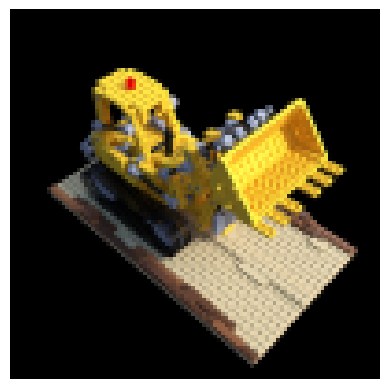

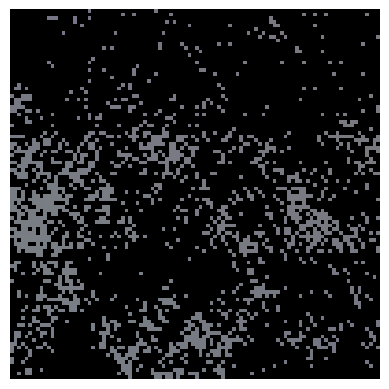

PSNR: 9.034971237182617
SSIM: 0.07855315506458282


In [ ]:
idx = 101
test_ray_o = ray_origins[idx].view(-1, 3)
test_ray_d = ray_directions[idx].view(-1, 3)

test_img = images[idx]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_img.cpu())
ax.axis('off')
plt.show()

pred_img = test(model_coarse, model_fine, test_ray_o, test_ray_d)

# (H, W, 3) -> (1, 3, H, W)
pred_img = pred_img.permute(2, 0, 1).unsqueeze(0).cpu()
test_img = test_img.permute(2, 0, 1).unsqueeze(0).cpu()

psnr = PeakSignalNoiseRatio(data_range=1.0)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
psnr_val = psnr(pred_img, test_img)
ssim_val = ssim(pred_img, test_img)
print(f'PSNR: {psnr_val}')
print(f'SSIM: {ssim_val}')

  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 0 Loss: 20.48251724243164


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 1 Loss: 16.222923278808594


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 2 Loss: 14.946489334106445


  0%|          | 0/977 [00:00<?, ?it/s]

Epoch 3 Loss: 15.304946899414062


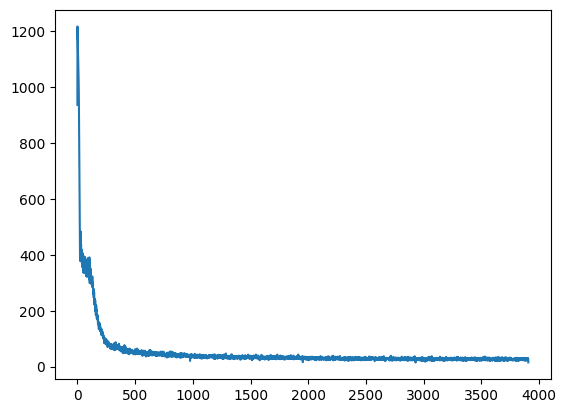

In [ ]:
losses = train(model_coarse, model_fine, optimizer, scheduler, dataloader, device=device, n_epochs=4,
               tn=2, tf=6, Nc=64, Nf=128, H=100, W=100, 
               freq=500, test_ray_o=test_ray_o, test_ray_d=test_ray_d,
               output_dir='output_hierarchical')
plt.plot(losses);

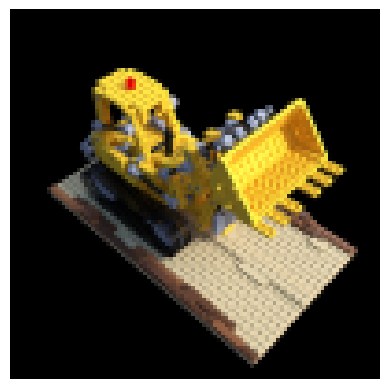

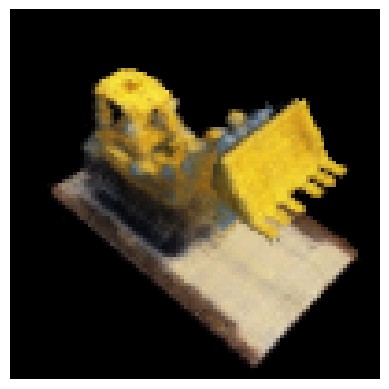

PSNR: 23.683073043823242
SSIM: 0.8382744789123535


In [ ]:
model_coarse = NeRF(hidden_dim=128).to(device)
model_fine = NeRF(hidden_dim=128).to(device)
model_coarse.load_state_dict(torch.load('output_hierarchical/model_coarse.pth', map_location=device, weights_only=True))
model_fine.load_state_dict(torch.load('output_hierarchical/model_fine.pth', map_location=device, weights_only=True))

idx = 101
test_ray_o = ray_origins[idx].view(-1, 3)
test_ray_d = ray_directions[idx].view(-1, 3)

test_img = images[idx]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(test_img.cpu())
ax.axis('off')
plt.show()

pred_img = test(model_coarse, model_fine, test_ray_o, test_ray_d)

# (H, W, 3) -> (1, 3, H, W)
pred_img = pred_img.permute(2, 0, 1).unsqueeze(0).cpu()
test_img = test_img.permute(2, 0, 1).unsqueeze(0).cpu()

psnr = PeakSignalNoiseRatio(data_range=1.0)
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
psnr_val = psnr(pred_img, test_img)
ssim_val = ssim(pred_img, test_img)
print(f'PSNR: {psnr_val}')
print(f'SSIM: {ssim_val}')

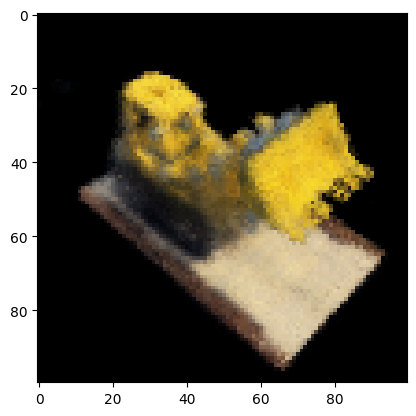

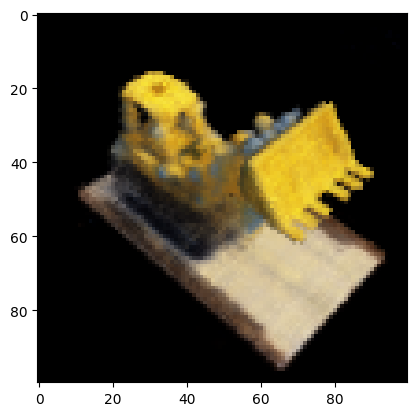

In [ ]:
_, _, H, W = test_img.shape
Nc = 64
Nf = 128

chunk_size = 10
with torch.inference_mode():
    pixels_coarse = []   # list of regenerated pixel values
    pixels_fine = []     # list of regenerated pixel values
    for i in range(int(np.ceil(H / chunk_size))):   # iterate over chunks
        # Get chunk of rays
        ray_o = test_ray_o[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)
        ray_d = test_ray_d[i * W * chunk_size: (i + 1) * W * chunk_size].to(device)        

        t_stratified = sample_stratified(ray_o, 2, 6, Nc, perturb=True)
        c, weights = render_rays(model_coarse, t_stratified, ray_o, ray_d)
        pixels_coarse.append(c)

        t_combined = sample_hierarchical(t_stratified, weights, Nf, perturb=True)
        c, _ = render_rays(model_fine, t_combined, ray_o, ray_d)
        pixels_fine.append(c)
    img_coarse = torch.cat(pixels_coarse).data.cpu().numpy().reshape(H, W, 3)
    img_fine = torch.cat(pixels_fine).data.cpu().numpy().reshape(H, W, 3)

plt.figure()
plt.imshow(img_coarse)
plt.show()

plt.figure()
plt.imshow(img_fine)
plt.show()